# Btc Moving Average Trade Strategy

## Download and process the data

In [13]:
import json
import time
import sys
from datetime import datetime
from urllib.request import Request, urlopen
from urllib.parse import urlencode
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import math as ma
import random

minute = 60
hour = minute*60
day = hour*24
week = day*7
month = day*30
year = day*365

# Possible Commands
PUBLIC_COMMANDS = [ 'returnTradeHistory', 'returnChartData','returnLoanOrders']

class Poloniex:
    def __init__(self):
        # Conversions
        self.timestamp_str = lambda timestamp=time.time(), format="%Y-%m-%d %H:%M:%S": datetime.fromtimestamp(timestamp).strftime(format)
        self.str_timestamp = lambda datestr=self.timestamp_str(), format="%Y-%m-%d %H:%M:%S": int(time.mktime(time.strptime(datestr, format)))
        self.float_roundPercent = lambda floatN, decimalP=2: str(round(float(floatN) * 100, decimalP))+"%"

        # PUBLIC COMMANDS
        
        self.marketChart = lambda pair, period, start=time.time()-(month*1), end=time.time(): self.api('returnChartData', {'currencyPair':pair, 'period':period, 'start':start, 'end':end})
        
        # the marketTradeHist data is before 2 days from today
        
        self.marketTradeHist = lambda pair, start=time.time()-(day*2), end=time.time(): self.api('returnTradeHistory',{'currencyPair':pair, 'start':start, 'end':end}) # NEEDS TO BE FIXED ON Poloniex
        self.marketLoans = lambda coin: self.api('returnLoanOrders',{'currency':coin})
        
    #####################
    # Main Api Function #
    #####################
    def api(self, command, args={}):
        """
        returns 'False' if invalid command or if no APIKey or Secret is specified (if command is "private")
        returns {"error":"<error message>"} if API error
        """
        if command in PUBLIC_COMMANDS:
            url = 'https://poloniex.com/public?'
            args['command'] = command
            ret = urlopen(Request(url + urlencode(args)))
            return json.loads(ret.read().decode(encoding='UTF-8'))
        else:
            return False


In [2]:
Pol = Poloniex()
pair = 'USDT_BTC'
period = 300
MarketChart = pd.DataFrame(Pol.marketChart(pair, period))
for i in MarketChart.index:
    
    MarketChart.loc[i, 'date_str'] = Pol.timestamp_str(MarketChart.loc[i, 'date'])
MarketChart[ 'date_str'] =  pd.DatetimeIndex(MarketChart['date_str'])
MarketChart.set_index(keys = 'date_str', inplace = True)

In [18]:
MarketChart.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
date_str,,,,,,,,
2019-04-01 09:15:57,4130.318509,1554081357,4130.318509,4130.318509,4130.318509,0.000000,0.000000,4130.318509
2019-04-01 09:20:00,4122.456512,1554081600,4130.318509,4122.456512,4130.318509,0.421827,1740.165971,4125.304878
2019-04-01 09:25:00,4122.910000,1554081900,4122.910000,4122.910000,4122.910000,0.043845,180.769896,4122.910000
2019-04-01 09:30:00,4123.500000,1554082200,4125.073123,4123.500000,4125.012460,0.927276,3823.631369,4123.511473
2019-04-01 09:35:00,4124.514492,1554082500,4124.514492,4121.595999,4122.156512,2.682758,11057.577211,4121.720672


In [3]:
MarketTradeHist = pd.DataFrame(Pol.marketTradeHist(pair))
MarketTradeHist[ 'date'] =  pd.DatetimeIndex(MarketTradeHist['date'])
MarketTradeHist.set_index(keys = 'date', inplace = True)
MarketTradeHist = MarketTradeHist.sort_index()
MarketTradeHist.rename(columns = {'rate':'trade_price'}, inplace = True)
MarketTradeHist.rename(columns = {'amount':'trade_qty'}, inplace = True)

In [4]:
MarketTradeHist.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-30 00:01:32,0.05722547,415054900,260151580129,5242.41999992,299.99994843,26743886,sell
2019-04-30 00:01:37,0.00309658,415054936,260151617092,5242.41999992,16.23357292,26743887,sell
2019-04-30 00:01:38,0.00309659,415054940,260151625084,5242.41999992,16.23362534,26743888,sell
2019-04-30 00:01:39,0.00309660,415054941,260151632077,5242.41999992,16.23367777,26743889,sell
2019-04-30 00:04:45,0.10506392,415055078,260152197511,5245.39999999,551.10228596,26743890,sell


In [5]:
MarketTradeHist.tail()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-01 23:59:31,0.24991100,415198433,260702018140,5395.60000000,1348.41979160,26751145,sell
2019-05-02 00:00:11,0.02402839,415198485,260702242915,5387.30000000,129.44814544,26751146,sell
2019-05-02 00:00:15,0.01840435,415198491,260702262895,5387.30000000,99.14975475,26751147,sell
2019-05-02 00:00:27,0.07796741,415198520,260702315842,5387.30000000,420.03382789,26751148,sell
2019-05-02 00:01:14,0.00054000,415198569,260702487670,5388.18000000,2.90961720,26751149,buy


In [155]:
MarketLoans = Pol.marketLoans('BTC')

In [156]:
MarketLoans_offers = pd.DataFrame(MarketLoans['offers'])

In [157]:
MarketLoans_offers.head()

,amount,rangeMax,rangeMin,rate
0,0.23825301,2,2,0.00006680
1,0.47051983,2,2,0.00006700
2,0.00800000,2,2,0.00006738
3,59.00719599,2,2,0.00006800
4,16.38189536,2,2,0.00006801


In [163]:
MarketLoans_offers[['amount', 'rate']] = MarketLoans_offers[['amount', 'rate']].astype('float')

In [9]:
order_quantity = 5

In [166]:
remaining_loan = order_quantity
loan_day_interest = 0
for index , row in MarketLoans_offers.iterrows():
    if remaining_loan > 0:
        loan_amount = min(remaining_loan, MarketLoans_offers.loc[index, 'amount'])
        remaining_loan -= loan_amount
        loan_day_interest += loan_amount * MarketLoans_offers.loc[index, 'rate']
average_loan_day_interest_rate = loan_day_interest / order_quantity
average_loan_day_interest_rate

6.784772331159999e-05

In [11]:
MarketTradeHist['trade_qty'] = MarketTradeHist['trade_qty'].astype('float')
MarketTradeHist['trade_price'] = MarketTradeHist['trade_price'].astype('float')

In [14]:
trade_start_hour1 = random.randint(0, 19)

In [46]:

pydatetime = MarketTradeHist.index.to_pydatetime()
date_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydatetime )
date_s = pd.Series(date_array)

In [47]:

date_s[0]

'2019-04-30'

In [97]:
start_time1 =  date_s[0] + ' ' + str(trade_start_hour1) + ':00:00'
end_time1 = date_s[0] + ' ' + str(trade_start_hour1 + 4) + ':00:00'

In [98]:
start_time1

'2019-04-30 4:00:00'

In [99]:
end_time1

'2019-04-30 8:00:00'

In [100]:
daytrades1 = MarketTradeHist[start_time1: end_time1]

In [101]:
daytrades1.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-30 04:01:07,0.010733,415065289,260198795866,5218.600000,56.01191221,26744390,sell
2019-04-30 04:01:07,0.000192,415065287,260198795866,5218.821494,1.00091777,26744388,sell
2019-04-30 04:01:07,0.000192,415065288,260198795866,5218.755925,1.00090519,26744389,sell
2019-04-30 04:09:40,0.001700,415065635,260199855805,5215.852529,8.86694929,26744391,sell
2019-04-30 04:12:27,0.001854,415065777,260200063597,5215.852529,9.66815640,26744392,buy


In [102]:
daytrades1.tail()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-30 07:58:36,0.057000,415075035,260232891736,5220.029091,297.54165817,26744772,sell
2019-04-30 07:59:16,0.001915,415075043,260233070557,5220.460474,9.99890455,26744773,buy
2019-04-30 07:59:38,0.057000,415075052,260233114513,5220.960474,297.59474701,26744774,sell
2019-04-30 07:59:51,0.010531,415075053,260233137490,5222.700000,55.00004479,26744775,buy
2019-04-30 07:59:54,0.000616,415075060,260233143484,5221.290693,3.21657613,26744776,sell


In [106]:
trade_start_hour2 = random.randint(0, 19)

In [107]:
datetime1 = datetime.datetime.strptime(date_s[0],'%Y-%m-%d')
tomorrow = datetime1 + datetime.timedelta(days = + 1)
start_time2 = str(tomorrow) + ' ' + str(trade_start_hour2) + ':00:00'
end_time2 = str(tomorrow) + ' ' + str(trade_start_hour2 + 4) + ':00:00'
daytrades2 = MarketTradeHist[start_time2: end_time2]

In [108]:
daytrades2.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-05-01 05:01:50,0.000500,415143717,260470997392,5342.337271,2.67116863,26748323,sell
2019-05-01 05:08:12,0.030000,415143898,260472175213,5347.002100,160.41006300,26748324,sell
2019-05-01 05:08:30,0.030087,415143906,260472219169,5351.748353,161.01810622,26748325,buy
2019-05-01 05:23:08,0.000132,415144287,260475398986,5353.599998,0.70517619,26748326,buy
2019-05-01 05:23:30,0.032700,415144307,260475487897,5347.500100,174.86325327,26748327,sell


In [109]:
trade_start_hour2

5

In [170]:
pydatetime2 = daytrades2.index.to_pydatetime()
time_array = np.vectorize(lambda s: s.strftime('%H:%M:%S'))(pydatetime2 )
time_s = pd.Series(time_array)
start_minute2 = int(time_s[0][4])
start_minute2

1

## calculate the trading related cost

In [110]:
%matplotlib inline
from scipy.ndimage.interpolation import shift
import time
import datetime
from sklearn import linear_model as linear_model
matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

### train VWAP Algo with train data

In [111]:

# now let's make some 1 minute data using resample
minute_data = pd.DataFrame()
minute_data['open'] = daytrades1['trade_price'].resample('Min').first()
minute_data['close'] = daytrades1['trade_price'].resample('Min').last()
minute_data['high'] = daytrades1['trade_price'].resample('Min').max()
minute_data['low'] = daytrades1['trade_price'].resample('Min').min()
minute_data['volume'] = daytrades1['trade_qty'].resample('Min').sum()

In [112]:
for index , row in minute_data.iterrows():
    if np.isnan(minute_data.loc[index, 'open']):
        minute_data.loc[index, 'open'] =  minute_data.loc[index - 1, 'open']
        minute_data.loc[index, 'close'] =  minute_data.loc[index - 1, 'close']
        minute_data.loc[index, 'high'] =  minute_data.loc[index - 1, 'high']
        minute_data.loc[index, 'low'] =  minute_data.loc[index - 1, 'low']
        minute_data.loc[index, 'volume'] =  0.0

In [113]:
minute_data.head()

,open,close,high,low,volume
date,,,,,
2019-04-30 04:01:00,5218.6,5218.755925,5218.821494,5218.6,0.011117
2019-04-30 04:02:00,5218.6,5218.755925,5218.821494,5218.6,0.000000
2019-04-30 04:03:00,5218.6,5218.755925,5218.821494,5218.6,0.000000
2019-04-30 04:04:00,5218.6,5218.755925,5218.821494,5218.6,0.000000
2019-04-30 04:05:00,5218.6,5218.755925,5218.821494,5218.6,0.000000


In [114]:
# calculate the cumulative pct by day
minute_data[ 'accum_volume' ] = minute_data.groupby( [ minute_data.index.date ] ).cumsum()[ 'volume' ] 
minute_data[ 'accum_pct' ] = minute_data.groupby( [ minute_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [203]:
minute_data.head()

,open,close,high,low,volume,accum_volume,accum_pct,minute_bars
date,,,,,,,,
2019-04-30 04:01:00,5218.6,5218.755925,5218.821494,5218.6,0.011117,0.011117,0.00024,1
2019-04-30 04:02:00,5218.6,5218.755925,5218.821494,5218.6,0.000000,0.011117,0.00024,2
2019-04-30 04:03:00,5218.6,5218.755925,5218.821494,5218.6,0.000000,0.011117,0.00024,3
2019-04-30 04:04:00,5218.6,5218.755925,5218.821494,5218.6,0.000000,0.011117,0.00024,4
2019-04-30 04:05:00,5218.6,5218.755925,5218.821494,5218.6,0.000000,0.011117,0.00024,5


In [116]:
len(minute_data)

239

In [117]:
# add a minute bin
# start of date, calc in minutes
start_of_day = trade_start_hour1 * 60 
# get the time for each bin in minutes and subtract 9:30
minute_data[ 'minute_bars' ] = ( minute_data.index.hour * 60 ) + minute_data.index.minute - start_of_day

In [118]:
# arrange our data
minute_bars = minute_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_data[ 'accum_pct' ]

In [119]:
len(y)

239

In [120]:
# now do the regression
lm = linear_model.LinearRegression()
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9791836415756555

In [121]:
# do we have any null values?
y[y.isnull()]

Series([], Freq: T, Name: accum_pct, dtype: float64)

In [122]:
# coefficients
lm.coef_

array([ 6.31673321e-03,  1.61888434e-04, -2.38200483e-06,  1.14477202e-08,
       -1.86562338e-11])

In [123]:
lm.intercept_

-0.08494627205245275

In [124]:
# now do the regression with no intercept
lm2 = linear_model.LinearRegression( fit_intercept = False )
model = lm2.fit( X, y )
predictions = lm2.predict( X )

# Rsquared
lm2.score( X, y )

0.9772144190999884

In [125]:
lm2.coef_

array([ 1.11390709e-04,  3.00058366e-04, -3.67999375e-06,  1.68672115e-08,
       -2.69532978e-11])

In [126]:
lm2.intercept_

0.0

In [127]:
predictions[- 1]

0.9432779120384005

<function matplotlib.pyplot.show(*args, **kw)>

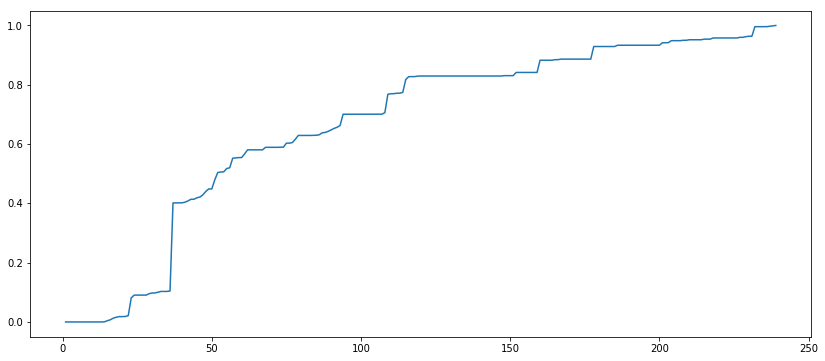

In [128]:
plt.plot(minute_data['minute_bars'], minute_data[ 'accum_pct' ])
plt.show

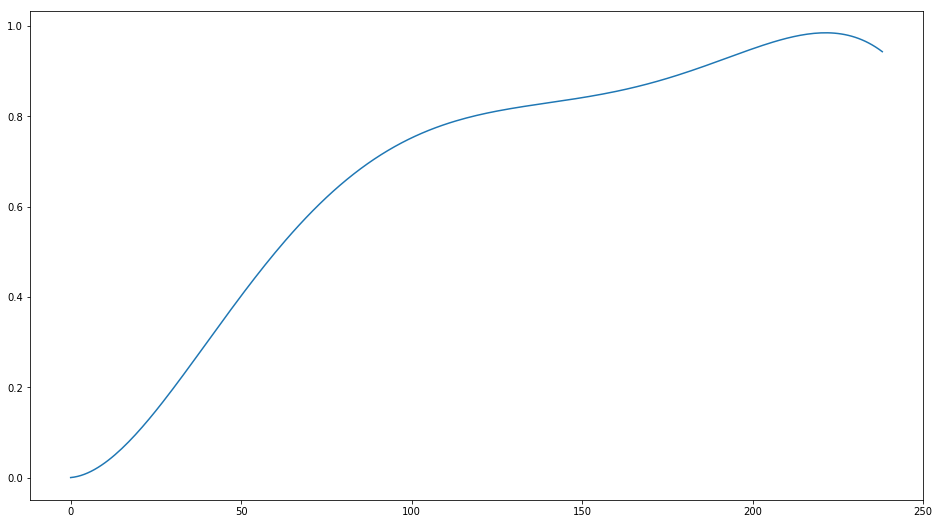

In [129]:
fig, ax1 = plt.subplots(figsize=(16,9))
plt.plot(predictions)

In [130]:
# or is there something about this that keeps it from getting to 1.0 that I'm forgetting?
minute_data.index

DatetimeIndex(['2019-04-30 04:01:00', '2019-04-30 04:02:00',
               '2019-04-30 04:03:00', '2019-04-30 04:04:00',
               '2019-04-30 04:05:00', '2019-04-30 04:06:00',
               '2019-04-30 04:07:00', '2019-04-30 04:08:00',
               '2019-04-30 04:09:00', '2019-04-30 04:10:00',
               ...
               '2019-04-30 07:50:00', '2019-04-30 07:51:00',
               '2019-04-30 07:52:00', '2019-04-30 07:53:00',
               '2019-04-30 07:54:00', '2019-04-30 07:55:00',
               '2019-04-30 07:56:00', '2019-04-30 07:57:00',
               '2019-04-30 07:58:00', '2019-04-30 07:59:00'],
              dtype='datetime64[ns]', name='date', length=239, freq='T')

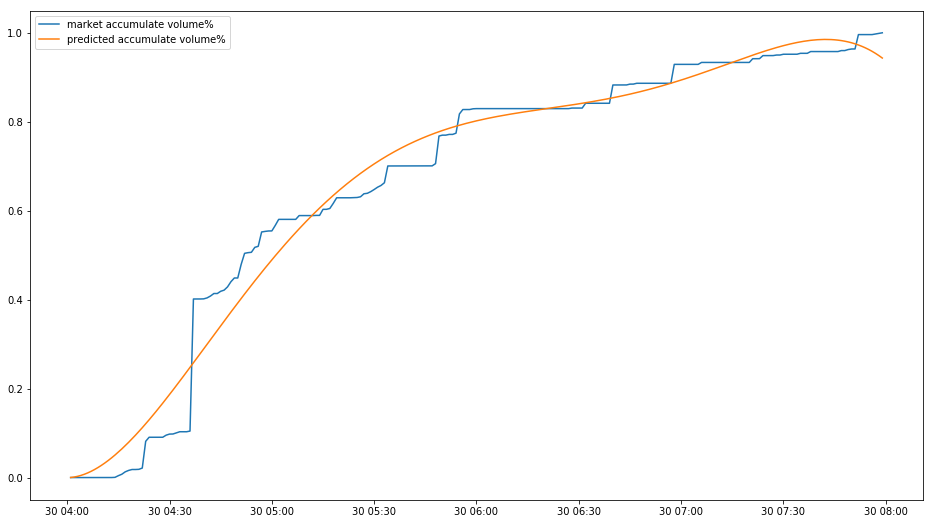

In [206]:

fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( minute_data[ 'accum_pct' ] , label = 'market accumulate volume%')
tgtsSeries = pd.Series( predictions )
tgtsSeries.index = minute_data.index
ax1.plot( tgtsSeries, label = 'predicted accumulate volume%')
plt.legend()
plt.show()

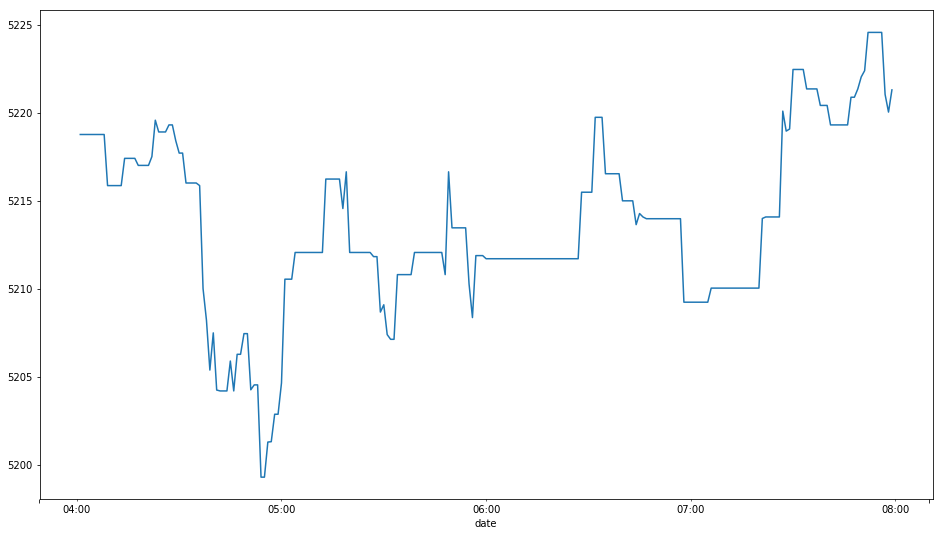

In [132]:
minute_data['close'].plot(figsize=(16,9))

### run a VWAP Algo with test data

In [133]:
len(predictions)

239

In [134]:
# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size ):
    bar_pcts = predictions
    bar_pcts = bar_pcts / predictions[ -1]
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( 'float' ), order_size )

In [136]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity )

In [137]:
len(order_targets)

239

In [147]:
order_targets[238]

5.0

In [84]:
trade_start_hour2

19

start loop : 2019-05-02 11:43:31:955778
end loop : 2019-05-02 11:43:32:027670
Btc volume: 31.77950552000004
order shares traded: 5.0
average price: 5347.221701166943
%trading_related_cost:0.0%
average trade size: 0.07142857142857142


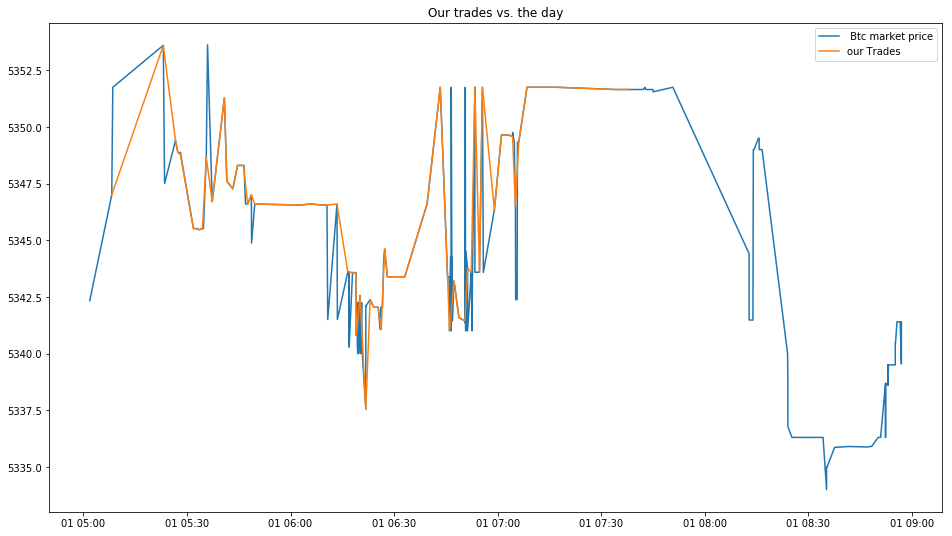

In [171]:
# initialize some other variables
current_bar = 1
current_target = 0
quantity_filled = 0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0
trades_arr = []
average_trades_price = 0
n = 1
trades_amount = 0
quantity_remaining = order_quantity
quantity_filled = 0
trading_related_cost = 0
# main event loop
show_time( 'start loop' )
for index, row in daytrades2.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = trade_start_hour2, minutes = start_minute2 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    last_price = row[ 'trade_price' ]
    last_quantity = row[ 'trade_qty' ]
        
    # collect volume
    total_volume += last_quantity
   
    # are we in a new minute?
    if ( minutes_from_open > current_bar ) and (current_bar < len(order_targets)):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
        # trade logic
        quantity_behind = current_target - quantity_filled
        if ( quantity_behind > 0 ): # we need to trade now
            new_trade_price = last_price
            new_trade_quantity = min(quantity_behind, last_quantity)
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
            
            # update quantity remaining
            quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity
            arrival_price = trades_arr[0][0]
            trading_related_cost += new_trade_quantity * (new_trade_price - arrival_price)
        
# looping done
show_time( 'end loop' )
#Now, let's look at some stats
        
trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )
print( 'Btc volume: ' + str( total_volume ) )
print( 'order shares traded: ' + str( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
trading_related_cost_pct = round(trading_related_cost / (order_quantity * arrival_price) * 100, 2)
print( 'average price: ' + str( avg_price ) )
print('%trading_related_cost:' + str(trading_related_cost_pct) + '%')
print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( daytrades2[ 'trade_price' ], label = ' Btc market price' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()
plt.show()



In [149]:
trading_fee_pct = 0.2
trading_cost_pct = trading_fee_pct + trading_related_cost_pct

## Moving Average Margin Trade Strategy

### calculate EMA

In [150]:

ema = []
for j in range(1, 20):
    ema.append(MarketChart['close'].ewm(span = 10 * j).mean())


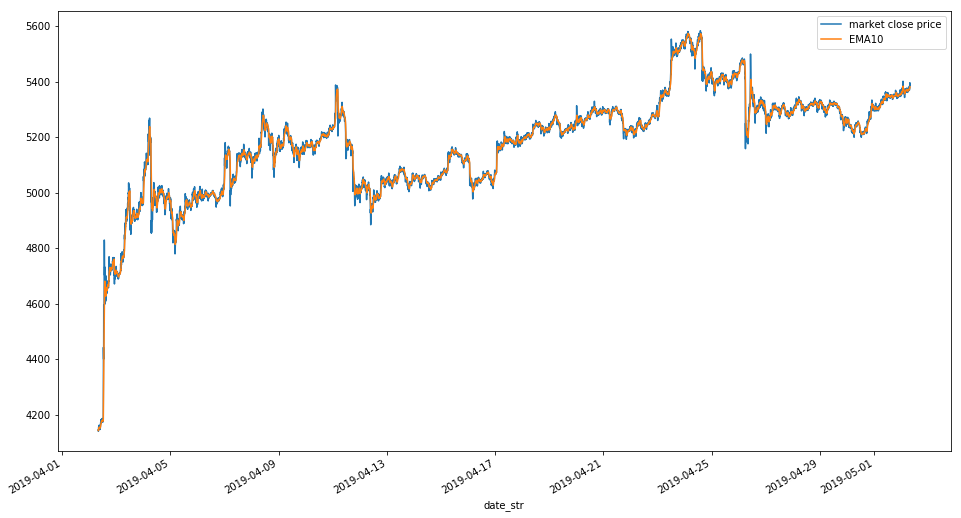

In [207]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
plt.plot(MarketChart.index, ema[0], label = 'EMA10')
plt.legend()
plt.show()

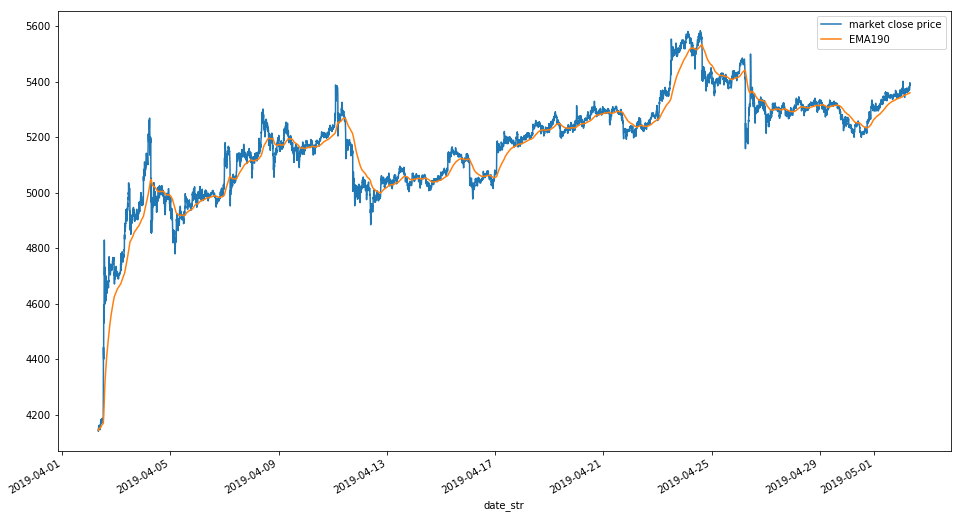

In [208]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
plt.plot(MarketChart.index, ema[18], label = 'EMA190')
plt.legend()
plt.show()

### calculate the difference pecentage between close and ema

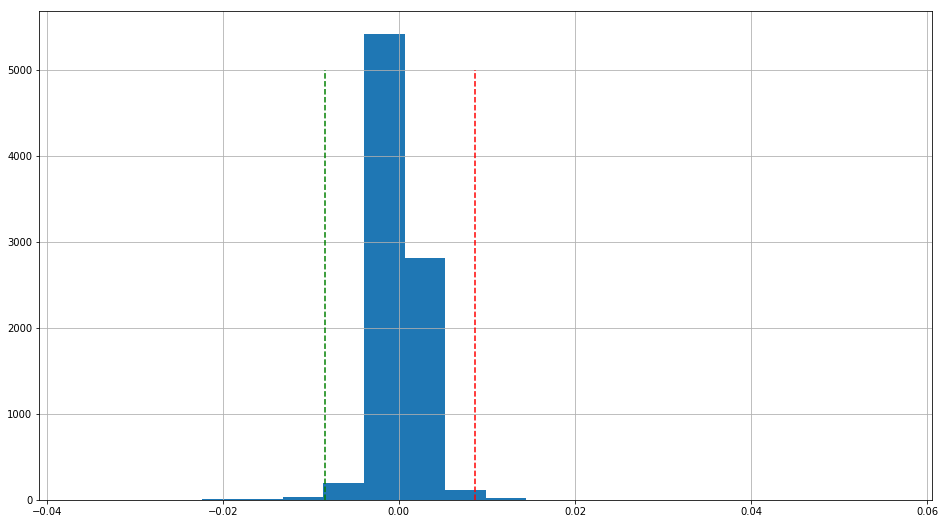

j=0 diff_pct_close_vs_ema_negative_unnormal: -0.008 diff_pct_close_vs_ema_min: -0.036 diff_pct_close_vs_ema_max:0.056 diff_pct_close_vs_ema_positive_unnormal: 0.009


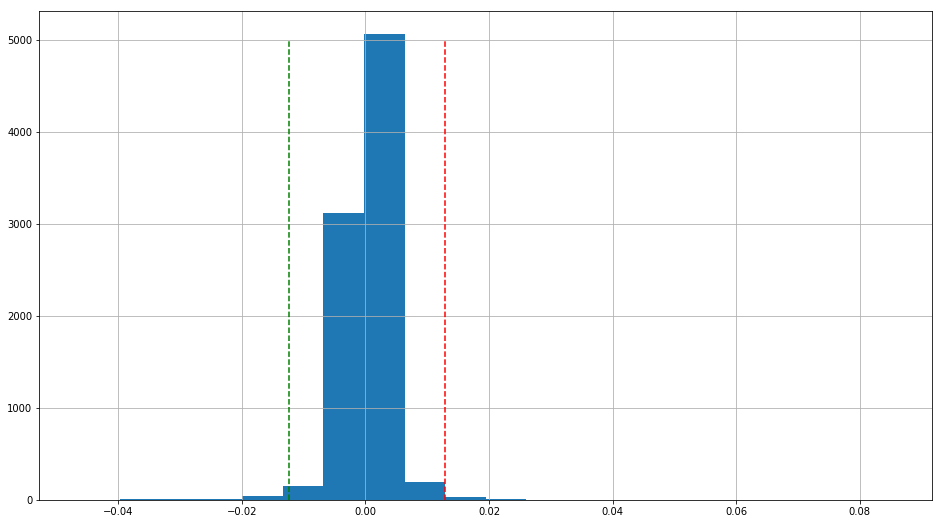

j=1 diff_pct_close_vs_ema_negative_unnormal: -0.012 diff_pct_close_vs_ema_min: -0.046 diff_pct_close_vs_ema_max:0.085 diff_pct_close_vs_ema_positive_unnormal: 0.013


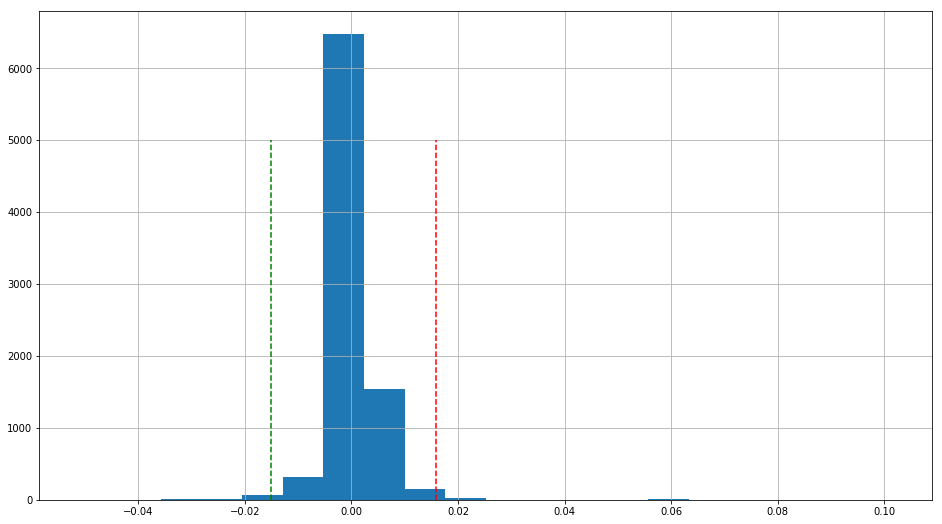

j=2 diff_pct_close_vs_ema_negative_unnormal: -0.015 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.101 diff_pct_close_vs_ema_positive_unnormal: 0.016


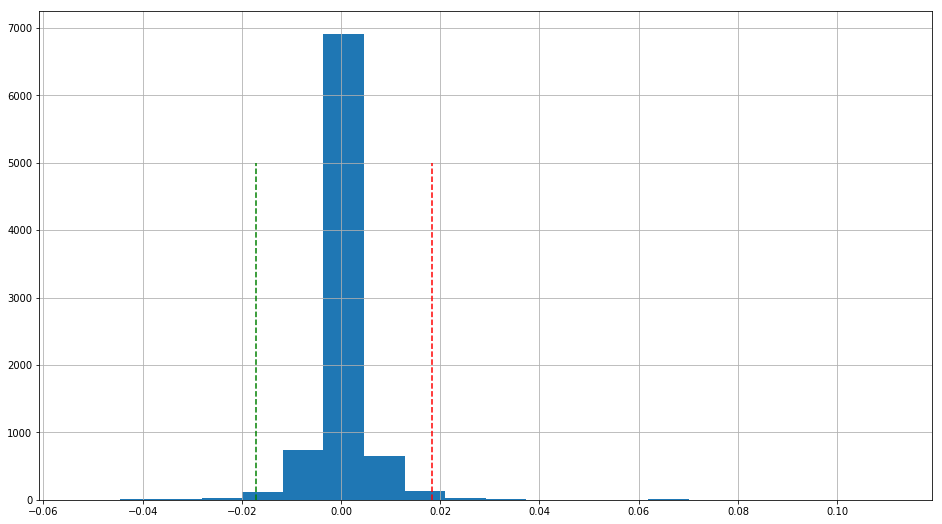

j=3 diff_pct_close_vs_ema_negative_unnormal: -0.017 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.111 diff_pct_close_vs_ema_positive_unnormal: 0.018


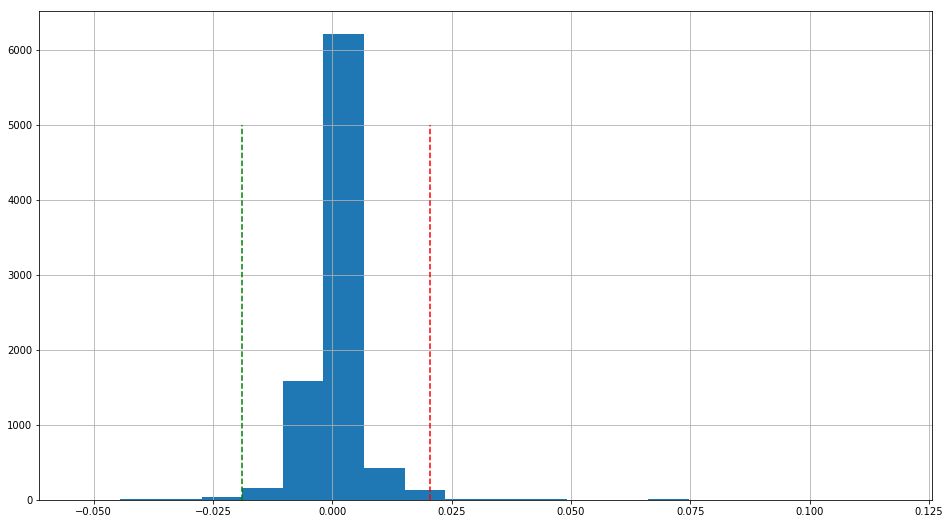

j=4 diff_pct_close_vs_ema_negative_unnormal: -0.019 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.117 diff_pct_close_vs_ema_positive_unnormal: 0.020


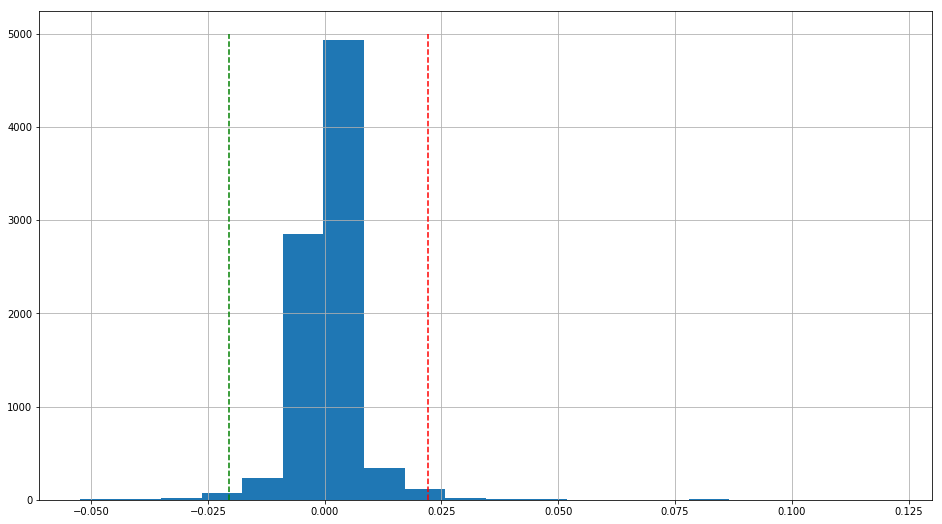

j=5 diff_pct_close_vs_ema_negative_unnormal: -0.020 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.121 diff_pct_close_vs_ema_positive_unnormal: 0.022


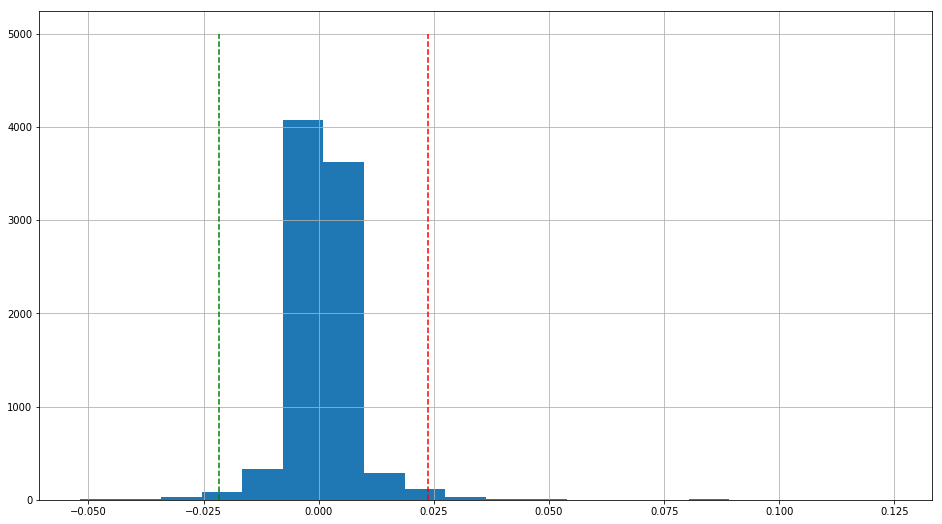

j=6 diff_pct_close_vs_ema_negative_unnormal: -0.022 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.124 diff_pct_close_vs_ema_positive_unnormal: 0.024


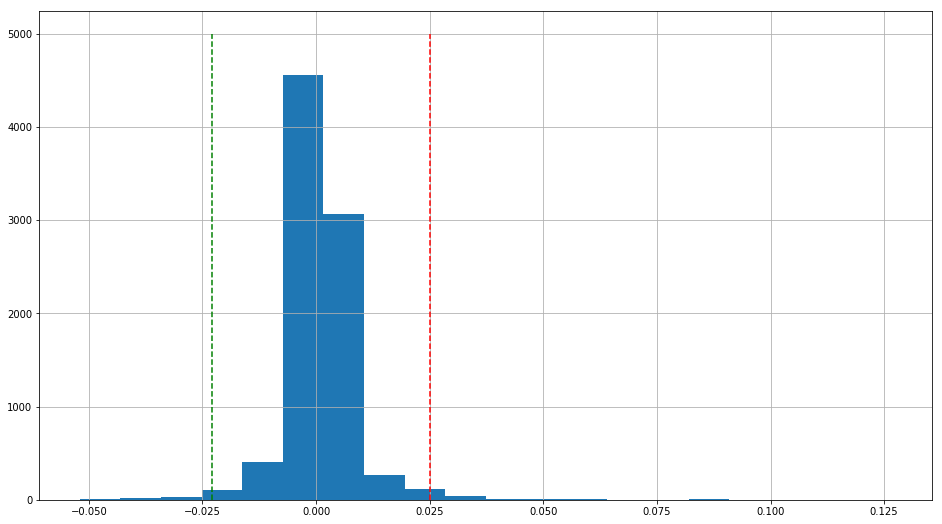

j=7 diff_pct_close_vs_ema_negative_unnormal: -0.023 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.127 diff_pct_close_vs_ema_positive_unnormal: 0.025


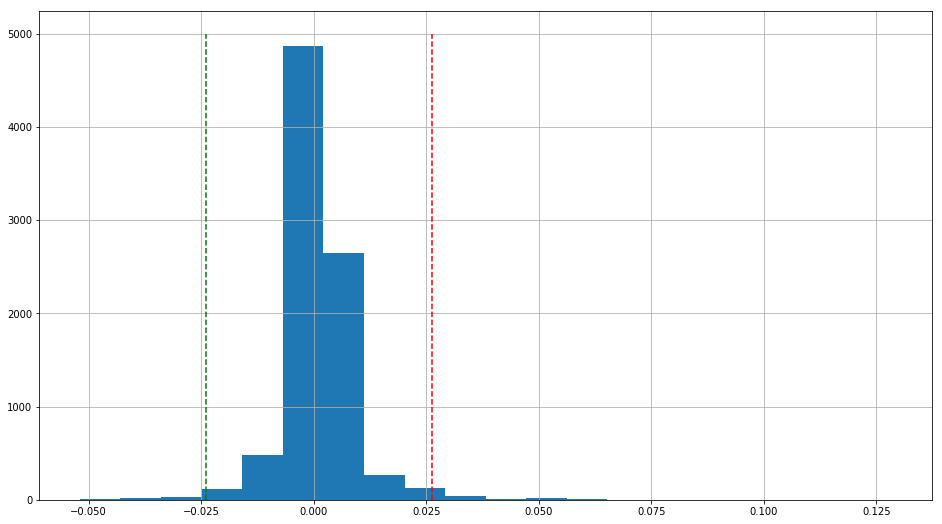

j=8 diff_pct_close_vs_ema_negative_unnormal: -0.024 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.128 diff_pct_close_vs_ema_positive_unnormal: 0.026


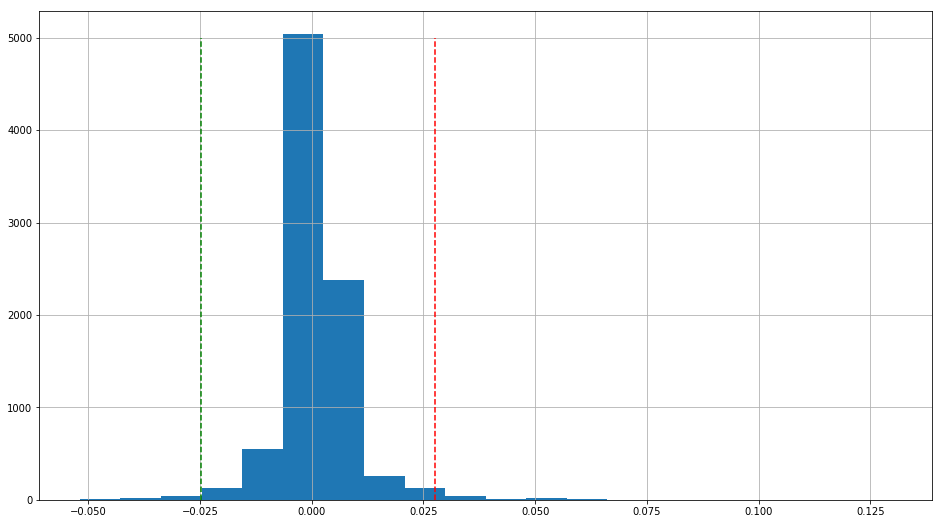

j=9 diff_pct_close_vs_ema_negative_unnormal: -0.025 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.130 diff_pct_close_vs_ema_positive_unnormal: 0.027


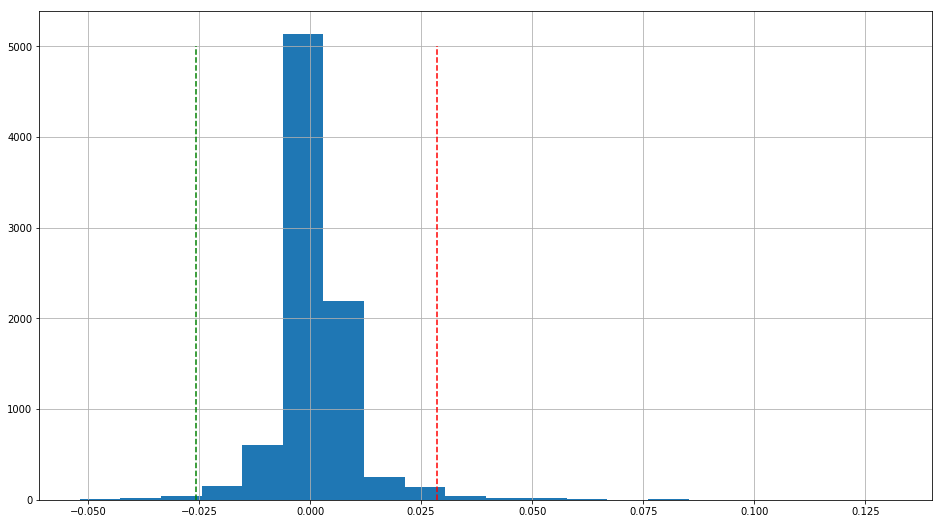

j=10 diff_pct_close_vs_ema_negative_unnormal: -0.026 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.131 diff_pct_close_vs_ema_positive_unnormal: 0.029


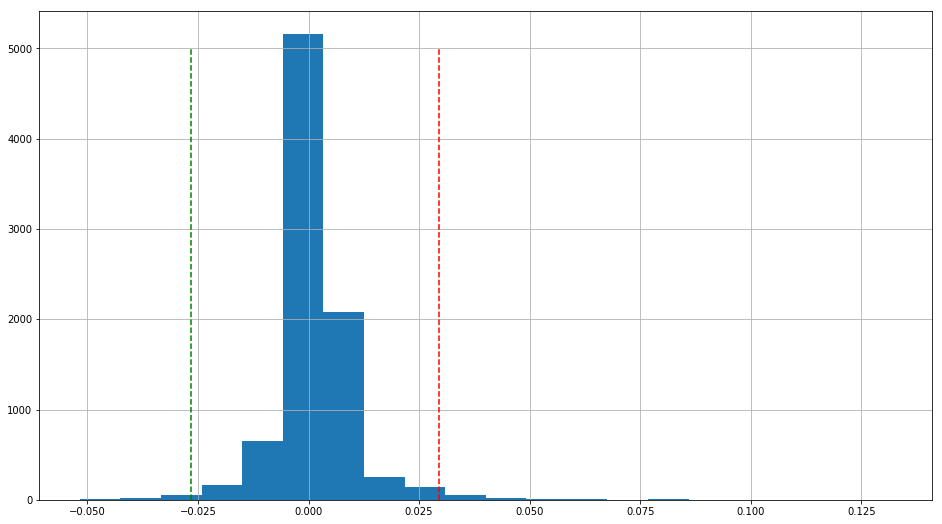

j=11 diff_pct_close_vs_ema_negative_unnormal: -0.026 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.132 diff_pct_close_vs_ema_positive_unnormal: 0.030


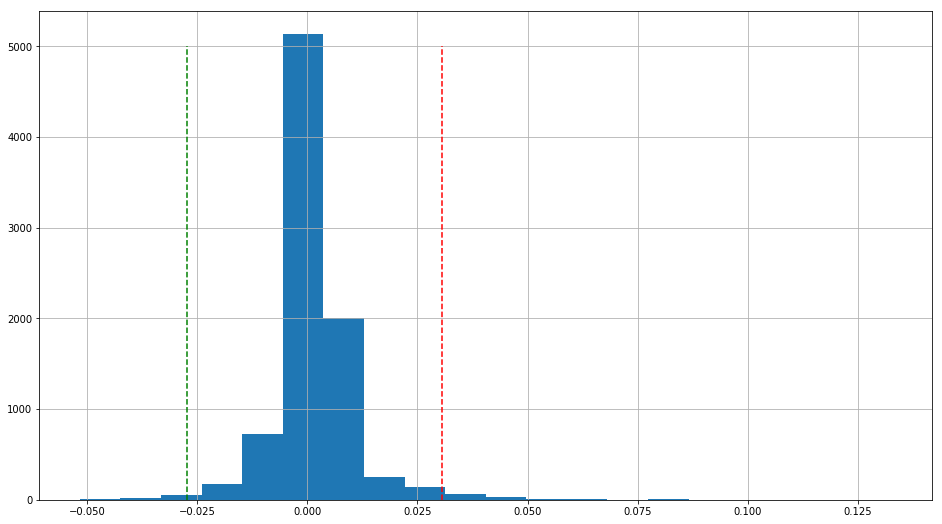

j=12 diff_pct_close_vs_ema_negative_unnormal: -0.027 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.133 diff_pct_close_vs_ema_positive_unnormal: 0.031


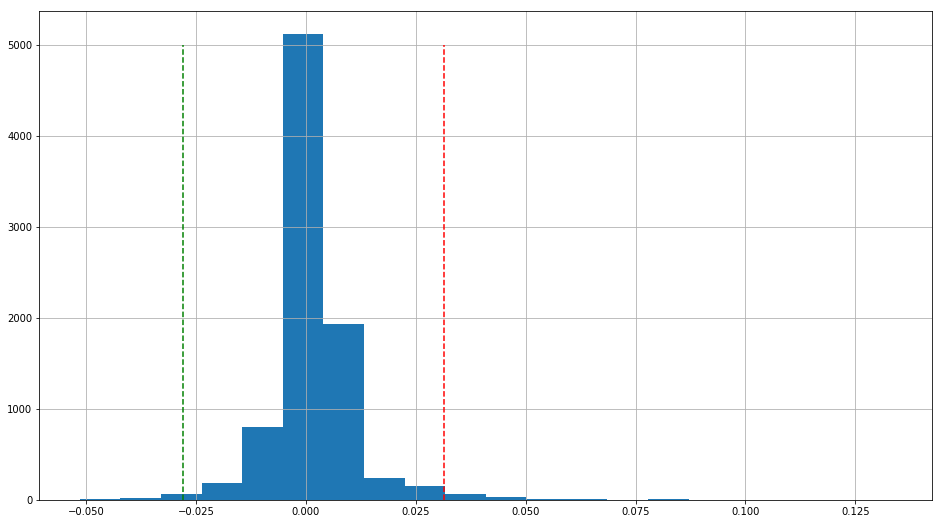

j=13 diff_pct_close_vs_ema_negative_unnormal: -0.028 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.133 diff_pct_close_vs_ema_positive_unnormal: 0.032


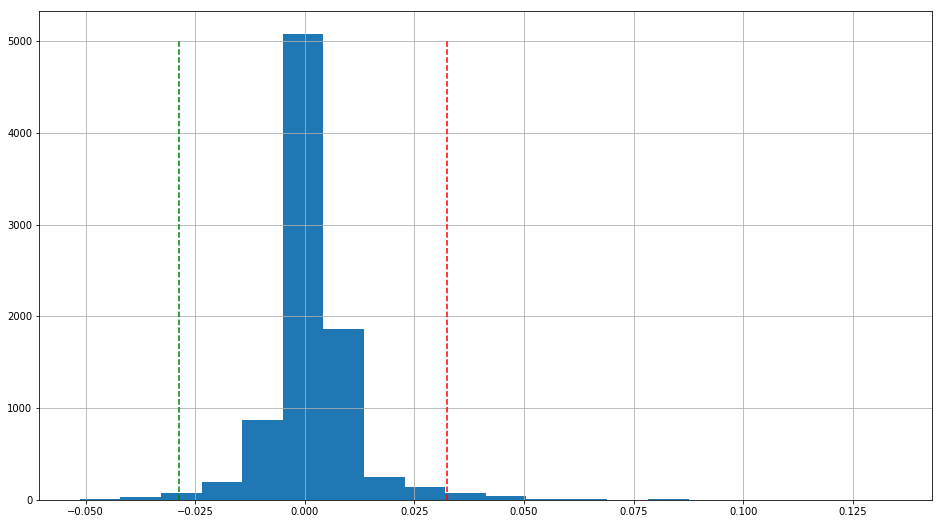

j=14 diff_pct_close_vs_ema_negative_unnormal: -0.029 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.134 diff_pct_close_vs_ema_positive_unnormal: 0.032


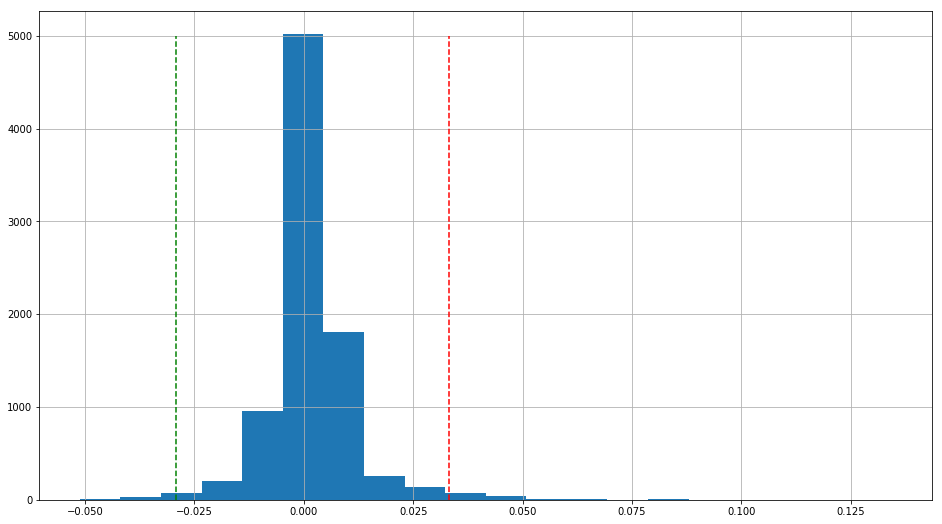

j=15 diff_pct_close_vs_ema_negative_unnormal: -0.029 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.134 diff_pct_close_vs_ema_positive_unnormal: 0.033


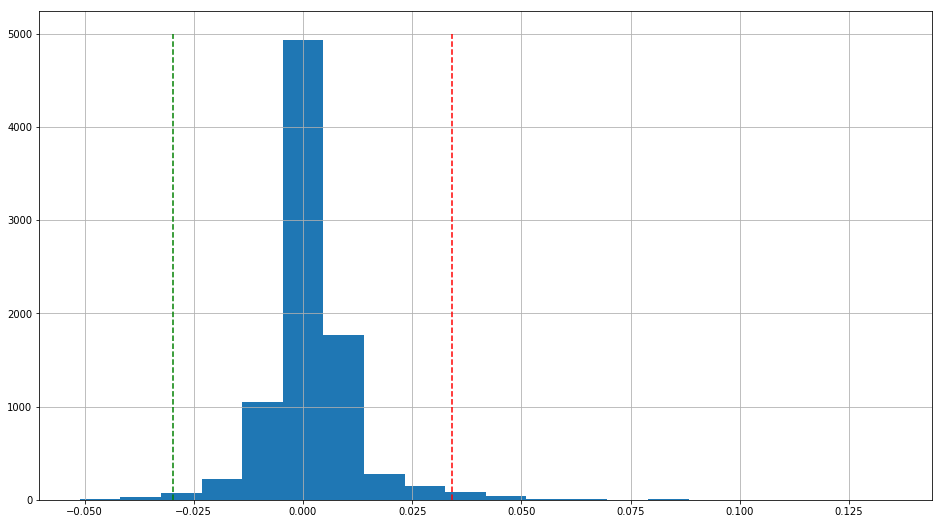

j=16 diff_pct_close_vs_ema_negative_unnormal: -0.030 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.135 diff_pct_close_vs_ema_positive_unnormal: 0.034


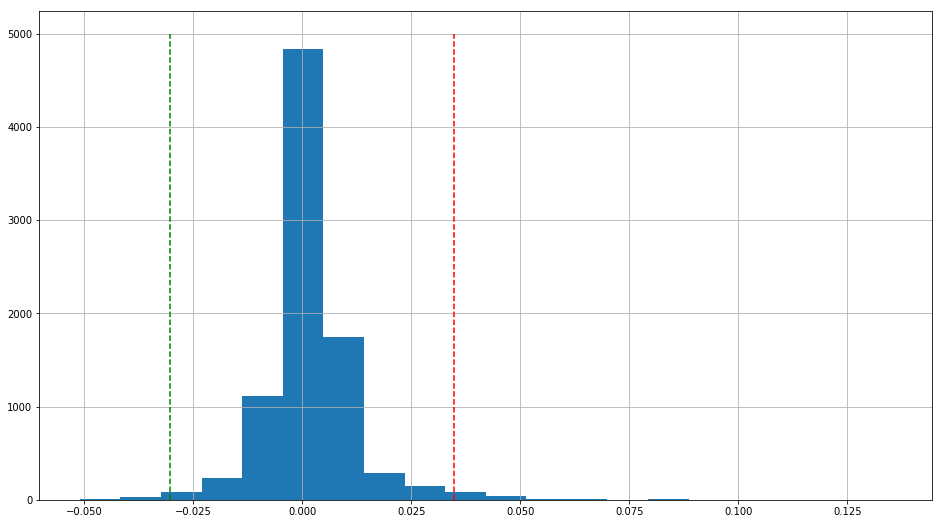

j=17 diff_pct_close_vs_ema_negative_unnormal: -0.030 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.135 diff_pct_close_vs_ema_positive_unnormal: 0.035


In [154]:


diff_pct_close_vs_ema = []
diff_pct_close_vs_ema_mean = []
diff_pct_close_vs_ema_std = []
diff_pct_close_vs_ema_negative_unnormal = []
diff_pct_close_vs_ema_positive_unnormal = []
diff_pct_close_vs_ema_max = []
diff_pct_close_vs_ema_min = []
for j in range(18):
    diff_pct_close_vs_ema.append((MarketChart['close'] - ema[j])/ ema[j])
    diff_pct_close_vs_ema_mean.append(diff_pct_close_vs_ema[j].mean())
    diff_pct_close_vs_ema_std.append(diff_pct_close_vs_ema[j].std())
    diff_pct_close_vs_ema_negative_unnormal.append(diff_pct_close_vs_ema_mean[j] - 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_positive_unnormal.append(diff_pct_close_vs_ema_mean[j] + 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_max.append(diff_pct_close_vs_ema[j].max())
    diff_pct_close_vs_ema_min.append(diff_pct_close_vs_ema[j].min())
    diff_pct_close_vs_ema[j].hist(bins=20,figsize=(16,9))
    plt.vlines(diff_pct_close_vs_ema_negative_unnormal[j], 0, 5000, colors = "green", linestyles = "dashed")
    plt.vlines(diff_pct_close_vs_ema_positive_unnormal[j], 0, 5000, colors = "red", linestyles = "dashed")
    plt.show()
    print('j={0} diff_pct_close_vs_ema_negative_unnormal: {1:.3f} diff_pct_close_vs_ema_min: {2:.3f} diff_pct_close_vs_ema_max:{3:.3f} diff_pct_close_vs_ema_positive_unnormal: {4:.3f}'.format(j, diff_pct_close_vs_ema_negative_unnormal[j], diff_pct_close_vs_ema_min[j], diff_pct_close_vs_ema_max[j], diff_pct_close_vs_ema_positive_unnormal[j]))

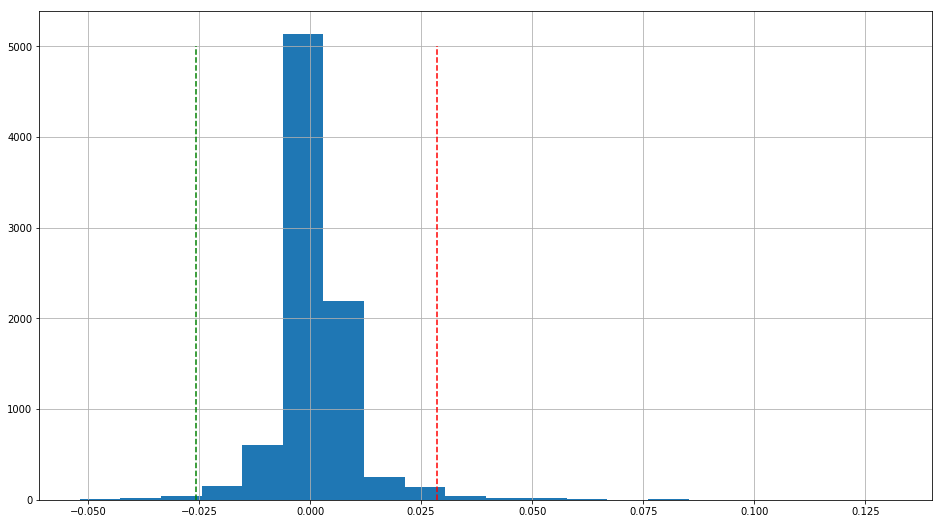

j=10 diff_pct_close_vs_ema_negative_unnormal: -0.026 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.131 diff_pct_close_vs_ema_positive_unnormal: 0.029


In [210]:
diff_pct_close_vs_ema[10].hist(bins=20,figsize=(16,9))
plt.vlines(diff_pct_close_vs_ema_negative_unnormal[10], 0, 5000, colors = "green", linestyles = "dashed")
plt.vlines(diff_pct_close_vs_ema_positive_unnormal[10], 0, 5000, colors = "red", linestyles = "dashed")
plt.show()
print('j={0} diff_pct_close_vs_ema_negative_unnormal: {1:.3f} diff_pct_close_vs_ema_min: {2:.3f} diff_pct_close_vs_ema_max:{3:.3f} diff_pct_close_vs_ema_positive_unnormal: {4:.3f}'.format(10, diff_pct_close_vs_ema_negative_unnormal[10], diff_pct_close_vs_ema_min[10], diff_pct_close_vs_ema_max[10], diff_pct_close_vs_ema_positive_unnormal[10]))

### select j and span

In [220]:

performance = {'j':[], 'final_pnl':[], 'win_rate':[]}
principle_dict = {'j':[], 'index':[], 'principle':[]}
sig_buy_list = []
sig_sell_list = []
signal_list = []
trade_price_dict ={'j':[], 'index':[], 'trade_price':[]}
for j in range(18):
    ## setup signal
    sig_buy = ma.ceil(diff_pct_close_vs_ema_negative_unnormal[j] * 1000) / 1000
    sig_buy_list.append(sig_buy)
    sig_sell = ma.floor(diff_pct_close_vs_ema_positive_unnormal[j] * 1000) / 1000
    sig_sell_list.append(sig_sell)
    index_stock_price = 1
    n_stock_price = len(MarketChart)
    sig = np.zeros(n_stock_price, dtype = np.int)
   
    for index_stock_price in range(n_stock_price):
        if diff_pct_close_vs_ema[j][index_stock_price - 1] <  sig_buy:
            sig[index_stock_price] = 1
        elif diff_pct_close_vs_ema[j][index_stock_price - 1] >= sig_sell:
            sig[index_stock_price] = - 1
        else:
            if sig[index_stock_price - 1] == 1:
                sig[index_stock_price] = 1
            elif sig[index_stock_price - 1] == 0:
                sig[index_stock_price] = 0
            elif sig[index_stock_price - 1] == - 1:
                sig[index_stock_price] = - 1
    signal = pd.Series(sig, index = MarketChart.index)
    signal_list.append(signal)
    # now let's accumulate some P&L
    position = 0
    principle = order_quantity * MarketChart.iloc[0, 0]
    
    #leverage = 1
    pnl = 0
    previous_signal = 0
    start_price = 0
    negative_pnl = 0
    positive_pnl = 0
    for index, row in MarketChart.iterrows():
        current_signal = signal.loc[index]
        if current_signal != previous_signal: # we need to do a trade
            # first check if we have an open position
            if position != 0: 
                # first we need to close the position and calculate P&L
                trade_price_dict['j'].append(j)
                trade_price_dict['index'].append(index)
                trade_price_dict['trade_price'].append(row['open'] * (1 - trading_cost_pct / 100))
                current_pnl = position * (row['open'] * (1 - trading_cost_pct / 100) - start_price)
                if position < 0:
                    principle += current_pnl
                else:
                    principle = trade_size * row['open'] * (1 - trading_cost_pct / 100)
                principle_dict['index'].append(index)
                principle_dict['principle'].append(principle)
                if current_pnl < 0:
                    negative_pnl += 1
                else:
                    positive_pnl += 1
                pnl += current_pnl
                
            # now open a new position
            principle_dict['index'].append(index)
            principle_dict['principle'].append(principle)
            trade_size = principle * (1 - trading_cost_pct / 100) / row['open'] 
            position = trade_size * current_signal # buy if signal is positive, sell if signal is negative
            start_price = row['open'] * (1+ trading_cost_pct / 100)
            trade_price_dict['j'].append(j)
            trade_price_dict['index'].append(index)
            trade_price_dict['trade_price'].append(start_price)
            previous_signal = current_signal
    win_rate = positive_pnl / (positive_pnl + negative_pnl) * 100
    performance['j'].append(j) 
    performance['final_pnl'].append(pnl)
    performance['win_rate'].append(win_rate)
    

In [221]:
len(trade_price_dict)

3

In [222]:
trade_price_df = pd.DataFrame(trade_price_dict)

In [229]:
trade_price_df.dtypes

j                       int64
index          datetime64[ns]
trade_price           float64
dtype: object

In [231]:
trade_price_df10 = trade_price_df[trade_price_df['j']== 10]

In [232]:
trade_price_df10.set_index(keys = 'index', inplace = True)

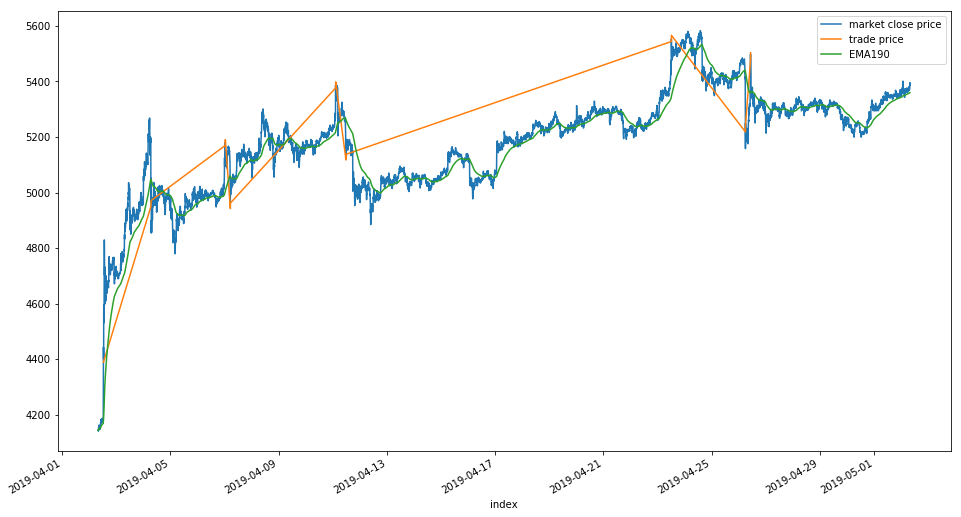

In [235]:
MarketChart['close'].plot(figsize=(16,9), label = 'market close price')
trade_price_df10['trade_price'].plot(figsize=(16,9), label = 'trade price')
plt.plot(MarketChart.index, ema[18], label = 'EMA190')
plt.legend()
plt.show()

In [195]:
## when final_pnl is the max
performance_df = pd.DataFrame(performance)
performance_df[performance_df['final_pnl'] == performance_df['final_pnl'].max()]
best_j = performance_df.index.values[performance_df['final_pnl'] == performance_df['final_pnl'].max()]

In [211]:
performance_df[performance_df['final_pnl'] == performance_df['final_pnl'].max()]

,j,final_pnl,win_rate
10,10,6210.284215,87.5


## calculate the annual return of EMA trade strategy

In [198]:
## calculate monthly retrun
monthly_return = performance_df.loc[best_j[0], 'final_pnl'] / principle 

## calculate annual return
annual_return = (monthly_return + 1) ** 12 - 1
annual_return

14.972791564988427

In [199]:
monthly_return

0.2597423664179955

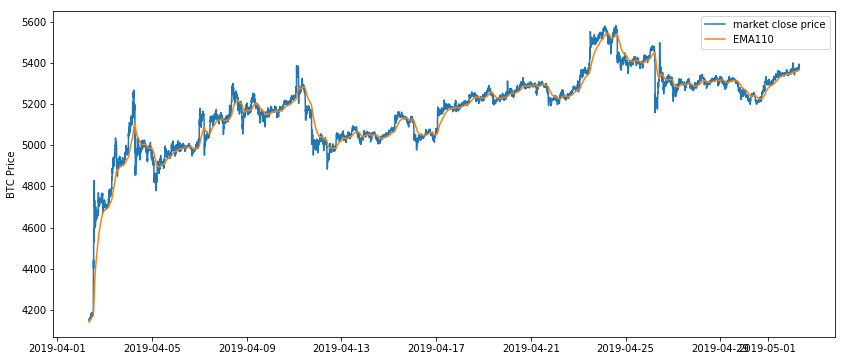

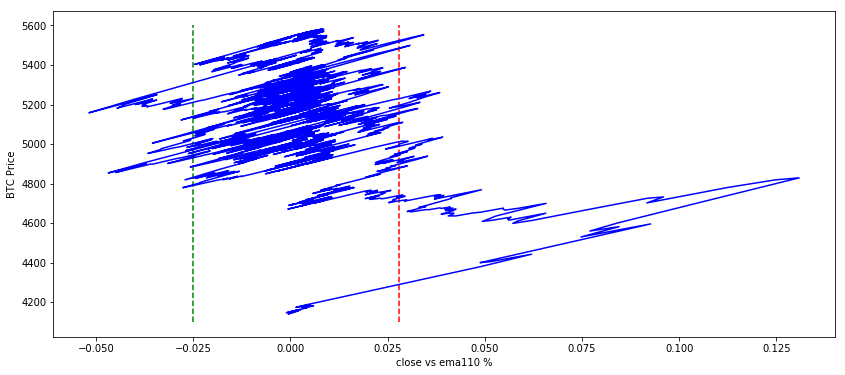

In [216]:
## Present the best strategy
register_matplotlib_converters()
plt.plot(MarketChart.index, MarketChart['close'], label = 'market close price')
plt.plot(MarketChart.index, ema[best_j[0]], label = 'EMA110')
plt.ylabel('BTC Price')
plt.legend()
plt.show()
plt.plot(diff_pct_close_vs_ema[best_j[0]], MarketChart['close'], "b-")
plt.xlabel('close vs ema{0:d} %'.format(110))
plt.ylabel('BTC Price')
plt.vlines(sig_buy_list[best_j[0]], 4100, 5600, colors = "green", linestyles = "dashed")
plt.vlines(sig_sell_list[best_j[0]], 4100, 5600, colors = "red", linestyles = "dashed")
plt.show()

In [201]:
## select min period of trading
signal_best = pd.Series(signal_list[best_j[0]])

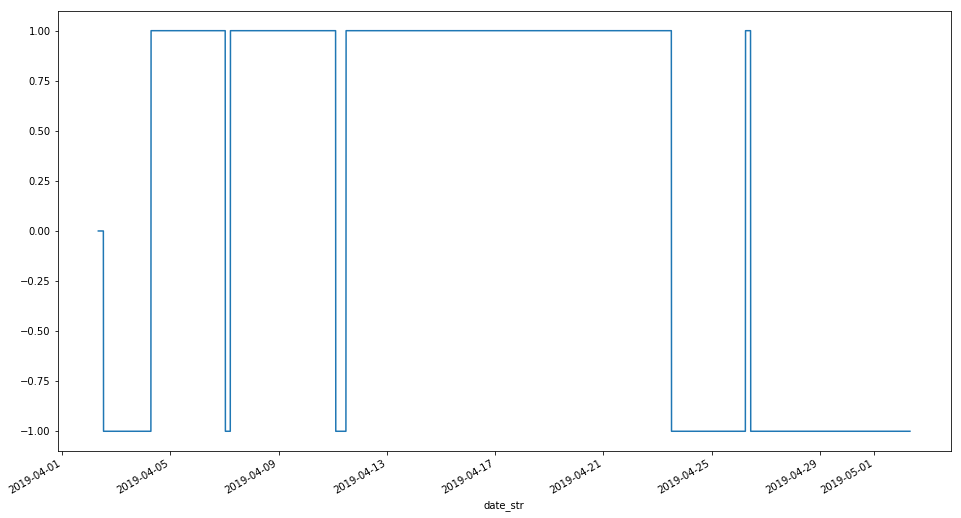

In [202]:
signal_best.plot(figsize=(16,9))